In [1]:
import requests
import lxml
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import re
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

In [2]:
def load_to_csv(df: pd.DataFrame, file_name: str):
    df.to_csv(file_name, index=False)

In [3]:
def load_dataset(file_name: str):
    return pd.read_csv(file_name)

In [4]:
def fix_genres_developers(df: pd.DataFrame): #Take only the first developer and genre
    for index in df.index:
        if ',' in df.loc[index, 'Genres']:
            temp = df.loc[index, 'Genres'].split(',')
            df.loc[index, 'Genres'] = temp[0]
        if ',' in df.loc[index, 'Developer']:
            temp = df.loc[index, 'Developer'].split(',')
            df.loc[index, 'Developer'] = temp[0]
            

In [5]:
def convert_str_to_numeric_data(df: pd.DataFrame):
    categorical_cols = ['Genres']
    df1 = df.copy()
    for col in categorical_cols:
        labels = df1[col].astype('category').cat.categories.tolist()
        replace_map_comp = {col: {k: v for k, v in zip(labels, list(range(len(labels) + 1)))}}
        df1.replace(replace_map_comp, inplace=True)

    return df1

In [6]:
def ranges_splitter(ranges):
    ranges = ranges.replace(" ","")
    min, max = ranges.split('..')
    return min.replace(",", ""), max.replace(",", "")

In [7]:
def get_data_from_steam(steam_store_link: str, s: requests.Session):
    only_p = SoupStrainer('div', attrs={"id": "userReviews"})
    request = s.get(steam_store_link)
    while request.status_code != 200:
        request = s.get(steam_store_link)
    soup = BeautifulSoup(request.content, 'lxml', parse_only=only_p)
    summary_columns = soup("div", attrs={"class": "summary column"})
    if len(summary_columns) == 1:
        s = summary_columns[0].get_text()
        if " ".join(s.split()) == 'No user reviews':
            return False
        if 'Need more user reviews to generate a score' in  " ".join(s.split()):
            return False
        spans = summary_columns[0].findAll("span")
    else:
        spans = summary_columns[1].findAll("span")
    
    temp = spans[1].get_text()
    temp = re.findall(r"[\d']+", temp)
    max_reviewers = int(''.join(temp))
    if len(spans) == 3:
        review_perc = int(spans[2].get_text().replace(" ", "").split('%')[0].split('-')[1])
    else:
        review_perc = 0
    
    return review_perc, max_reviewers

In [8]:
def get_data_from_steamspy_game_page(app_id: str, s: requests.Session):
    url = f"https://steamspy.com/{app_id}"
    only_p = SoupStrainer('div', attrs={"class": "panel-body"})
    genre_num = 0
    genres = ''
    request = s.get(url)
    soup = BeautifulSoup(request.content, 'lxml', parse_only=only_p)
    p = soup("p")[0]
    only_a = p.findAll("a")
    for element in only_a:
        if '/tag/Software' in element['href']: #detects if a game is a software
            return False #means this is not a game
        
        if element.get_text() == 'Store':
             steam_store_link = element['href']
             result = get_data_from_steam(steam_store_link, s)
             if result == False:
                 return False
             else:
                 review_perc, max_reviewers = result
        
        if '/genre/' in element['href']:
            if genre_num == 0:
                genres += element.get_text()
                genre_num += 1
            else:
                genres += ',' + element.get_text()
    return genres, review_perc, max_reviewers

In [9]:
def get_data_from_steamspy_into_dataframe(years: list):
    s = requests.Session()
    game_names = list()
    developer = list()
    minimum_owners = list()
    maximum_owners = list()
    prices = list()
    genres_list = list()
    review_percs = list()
    max_reviewers_list = list()
    years_list = list()
    exceptions = ['EA Play', 'Office Simulator', 'Steam Deck', 'Steam Deck Deposit'] #list of entries to filter
    for year in years:
        url = f"https://steamspy.com/year/{year}"
        request = s.get(url)
        only_the_table = SoupStrainer("table")
        soup = BeautifulSoup(request.content, 'lxml', parse_only=only_the_table)
        # Why did I use lxml parser and SoupStrainer? - https://stackoverflow.com/questions/25539330/speeding-up-beautifulsoup
        tbl = soup("table", attrs={"class": "table"})[0]
        for row in tbl("tr"):
            cells = row("td")
            if len(cells) > 0:
                game_name = " ".join(cells[1].a.get_text().split())
                print(game_name)
                if game_name in exceptions:
                    continue
                result = get_data_from_steamspy_game_page(cells[1].a['href'], s)
                if result == False:
                    continue
                else:
                    genres, review_perc, max_reviewers = result
                price = cells[3].get_text()
                if price == 'N/A':
                    continue
                elif price == 'Free':
                    price = 0
                    prices.append(price)
                else:
                    price = price.split('$')[1]
                    prices.append(float(price))
                game_names.append(game_name)
                developer.append(cells[7].get_text())
                min, max = ranges_splitter(cells[5].get_text())
                minimum_owners.append(int(min))
                maximum_owners.append(int(max))
                genres_list.append(genres)
                review_percs.append(float(review_perc / 100))
                max_reviewers_list.append(max_reviewers)
                years_list.append(year)
    
    df = pd.DataFrame({'Game Name': game_names,
                        'Developer': developer,
                        'Release year': years_list,
                        'Price': prices,
                        'Genres': genres_list,
                        'Review %': review_percs,
                        'Max Reviewers': max_reviewers_list,
                        'Minimum Owners': minimum_owners,
                        'Maximum Owners': maximum_owners})
    return df


In [ ]:
df = get_data_from_steamspy_into_dataframe([2021, 2020, 2019])
load_to_csv(df, 'full_dataset.csv')

In [8]:
df = load_dataset('./full_dataset.csv')
df

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,"Greg Lobanov, Alexis Dean-Jones, Lena Raine, M...",2021,15.99,"Adventure,Indie,RPG",0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,"Action,Adventure",0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,"Adventure,Indie",0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,"Adventure,Indie",0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,"Action,Adventure",0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13560,PC Building Simulator,"Claudiu Kiss, The Irregular Corporation",2019,7.99,"Indie,Simulation",0.94,32567,1000000,2000000
13561,Muse Dash,peropero,2019,1.49,"Action,Casual,Indie",0.00,49942,1000000,2000000
13562,People Playground,mestiez,2019,1.99,"Action,Casual,Indie,Simulation",0.98,76495,2000000,5000000
13563,Space Engineers,Keen Software House,2019,13.99,"Action,Indie,Simulation,Strategy,in Early Access",0.89,79661,2000000,5000000


In [8]:
load_to_csv(df.dropna(), 'dataset_no_nan.csv')

In [5]:
df_no_nan = load_dataset('./dataset_no_nan.csv')
df_no_nan

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,"Greg Lobanov, Alexis Dean-Jones, Lena Raine, M...",2021,15.99,"Adventure,Indie,RPG",0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,"Action,Adventure",0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,"Adventure,Indie",0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,"Adventure,Indie",0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,"Action,Adventure",0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13548,PC Building Simulator,"Claudiu Kiss, The Irregular Corporation",2019,7.99,"Indie,Simulation",0.94,32567,1000000,2000000
13549,Muse Dash,peropero,2019,1.49,"Action,Casual,Indie",0.00,49942,1000000,2000000
13550,People Playground,mestiez,2019,1.99,"Action,Casual,Indie,Simulation",0.98,76495,2000000,5000000
13551,Space Engineers,Keen Software House,2019,13.99,"Action,Indie,Simulation,Strategy,in Early Access",0.89,79661,2000000,5000000


In [10]:
df_fixed_genres_developers = df_no_nan.copy()
fix_genres_developers(df_fixed_genres_developers)

In [11]:
load_to_csv(df_fixed_genres_developers, 'dataset_fixed_genres_developers.csv')

In [21]:
df_fixed_genres_developers = load_dataset('./dataset_fixed_genres_developers.csv')

In [15]:
df_final = convert_str_to_numeric_data(df_fixed_genres_developers)

In [21]:
load_to_csv(df_final, 'converted_to_numeric.csv')

In [12]:
df_final = load_dataset('./converted_to_numeric.csv')
df_final

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,Greg Lobanov,2021,15.99,1,0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,0,0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,1,0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,1,0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,0,0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13548,PC Building Simulator,Claudiu Kiss,2019,7.99,10,0.94,32567,1000000,2000000
13549,Muse Dash,peropero,2019,1.49,0,0.00,49942,1000000,2000000
13550,People Playground,mestiez,2019,1.99,0,0.98,76495,2000000,5000000
13551,Space Engineers,Keen Software House,2019,13.99,0,0.89,79661,2000000,5000000


In [13]:
df_final['Maximum Owners'].corr(df_final['Max Reviewers'], method='pearson') # checking if there is correlation between Maximum Owners and Max Reviewers

0.8665487006979073

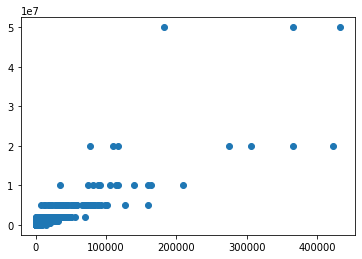

In [14]:
ct1 = pd.crosstab(df_final['Maximum Owners'], df_final['Max Reviewers'])
plt.scatter(df_final['Max Reviewers'], df_final['Maximum Owners'])

In [15]:
m=linear_model.LinearRegression().fit(df_final[['Max Reviewers']], df_final['Maximum Owners']) #building linear regression model based on Max Reviewers only

In [16]:
print("b1:",m.coef_)
print("b0:",m.intercept_)

b1: [85.47816642]
b0: 26478.207754451418


In [17]:
r2_score(df_final['Maximum Owners'].tolist(), m.predict(df_final.iloc[:,6:7]).flatten())

0.7509066506812327

C:\Users\MECHAVI\AppData\Local\Temp\ipykernel_9524\210461550.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_final['Max Reviewers'],m.predict(df_final.iloc[:,6:7]),'k',color='blue',linewidth=3)


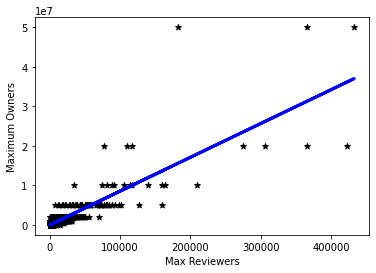

In [18]:
plt.scatter(x=df_final['Max Reviewers'],y=df_final['Maximum Owners'],c='k',marker='*',label='Max Reviewers')
plt.plot(df_final['Max Reviewers'],m.predict(df_final.iloc[:,6:7]),'k',color='blue',linewidth=3)

plt.xlabel('Max Reviewers')
plt.ylabel('Maximum Owners')
plt.show()

In [19]:
lr = linear_model.LinearRegression() # create a linear regression object

x = df_final[['Max Reviewers', 'Minimum Owners']]
y = df_final['Maximum Owners']
lr.fit(X=x, y=y)

LinearRegression()

In [20]:
print("Slope:",lr.coef_)
print("Intercept:",lr.intercept_)

Slope: [-5.62749583  2.39068376]
Intercept: 11749.945262759415


In [21]:
print("R2:",lr.score(x,y))
print("R2:",r2_score(y,lr.predict(x.values)))

R2: 0.9886054856355762
R2: 0.9886054856355762


C:\Users\MECHAVI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


                Release year     Price    Genres  Review %  Max Reviewers  \
Release year        1.000000  0.152024  0.000685  0.141946      -0.016466   
Price               0.152024  1.000000  0.135298  0.021131       0.105731   
Genres              0.000685  0.135298  1.000000 -0.025017      -0.007178   
Review %            0.141946  0.021131 -0.025017  1.000000       0.031562   
Max Reviewers      -0.016466  0.105731 -0.007178  0.031562       1.000000   
Minimum Owners     -0.016134  0.078794 -0.015797  0.013757       0.884350   
Maximum Owners     -0.015511  0.074732 -0.015460  0.013297       0.866549   

                Minimum Owners  Maximum Owners  
Release year         -0.016134       -0.015511  
Price                 0.078794        0.074732  
Genres               -0.015797       -0.015460  
Review %              0.013757        0.013297  
Max Reviewers         0.884350        0.866549  
Minimum Owners        1.000000        0.993930  
Maximum Owners        0.993930        1.

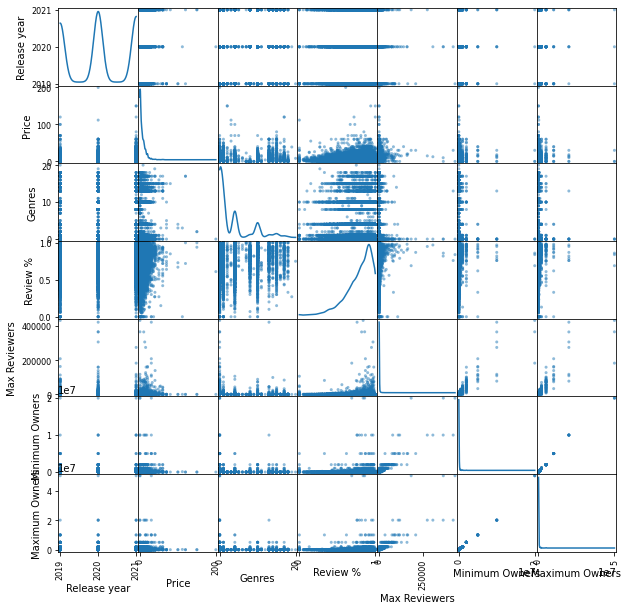

In [22]:
print(df_final.corr())
pd.plotting.scatter_matrix(df_final, figsize=(10, 10), diagonal='kde')
plt.show()